In [4]:
# Install gdown
# !pip install gdown

# Download the file from Google Drive
# https://drive.google.com/file/d/1oEtO0YA9nHr0H2unX4QR-2bHNX9b-FGz/view?usp=sharing

# !gdown --id 1_1vTv57QQcDCrbV6bzwpgTUZhd4y52ke
!gdown --id 1oEtO0YA9nHr0H2unX4QR-2bHNX9b-FGz
# Extract the tar file
import tarfile

# Open the tar file
with tarfile.open('Augumented_images_new.tar', 'r') as tar:
    tar.extractall()  # Extract to the current working directory

# List the extracted files to verify
import os

# Check the contents of the current directory
print(os.listdir())


/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1oEtO0YA9nHr0H2unX4QR-2bHNX9b-FGz
From (redirected): https://drive.google.com/uc?id=1oEtO0YA9nHr0H2unX4QR-2bHNX9b-FGz&confirm=t&uuid=ec5acb2d-2b9f-4771-8027-51c355048716
To: /kaggle/working/Augumented_images_new.tar
100%|████████████████████████████████████████| 167M/167M [00:02<00:00, 61.5MB/s]
['Augumented_images_new.tar', '.virtual_documents', 'Augumented_images_new']


In [5]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [6]:
# Function to remove hair from images
def apply_dullrazor(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_scale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray_scale, cv2.MORPH_BLACKHAT, kernel)
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)
    return dst

# Custom dataset to apply dullrazor and prepare data
class SkinCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Loop through subfolders and get image paths and labels
        for class_idx, class_folder in enumerate(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_folder)
            if os.path.isdir(class_path):
                for image_name in os.listdir(class_path):
                    image_path = os.path.join(class_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = apply_dullrazor(image_path)  # Apply dullrazor function
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transforms (no color-changing augmentations)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

# Load dataset and split
dataset = SkinCancerDataset(root_dir="/kaggle/working/Augumented_images_new", transform=transform)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [7]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 512 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomCNN(num_classes=8)  # 8 classes in the dataset
model = nn.DataParallel(model)    # Wrap the model for multiple GPUs
model = model.to(device) 

In [8]:
# Define the loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization


In [9]:
# Function to train and validate the model using GPUs
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100.0 * correct / total
        train_loss = running_loss / len(train_loader)
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        
        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100.0 * correct / total
        val_loss = val_loss / len(val_loader)
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
    
    return train_acc_history, val_acc_history, train_loss_history, val_loss_history

# Train the model
train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

# Save the model
torch.save(model.state_dict(), "skin_cancer_model.pth")


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/20, Train Loss: 1.9996, Train Acc: 20.45, Val Loss: 1.8188, Val Acc: 29.08
Epoch 2/20, Train Loss: 1.7840, Train Acc: 29.67, Val Loss: 1.6328, Val Acc: 37.97
Epoch 3/20, Train Loss: 1.5709, Train Acc: 40.49, Val Loss: 1.4971, Val Acc: 43.53
Epoch 4/20, Train Loss: 1.4690, Train Acc: 44.07, Val Loss: 1.4724, Val Acc: 45.29
Epoch 5/20, Train Loss: 1.4033, Train Acc: 46.16, Val Loss: 1.3460, Val Acc: 49.80
Epoch 6/20, Train Loss: 1.3243, Train Acc: 48.69, Val Loss: 1.3160, Val Acc: 50.65
Epoch 7/20, Train Loss: 1.2726, Train Acc: 50.69, Val Loss: 1.2755, Val Acc: 51.37
Epoch 8/20, Train Loss: 1.2009, Train Acc: 53.82, Val Loss: 1.1821, Val Acc: 55.95
Epoch 9/20, Train Loss: 1.1507, Train Acc: 55.95, Val Loss: 1.2410, Val Acc: 52.48
Epoch 10/20, Train Loss: 1.1175, Train Acc: 56.91, Val Loss: 1.1241, Val Acc: 56.54
Epoch 11/20, Train Loss: 1.0295, Train Acc: 60.38, Val Loss: 1.1402, Val Acc: 56.80
Epoch 12/20, Train Loss: 0.9728, Train Acc: 62.88, Val Loss: 1.1298, Val Acc: 58.04
E

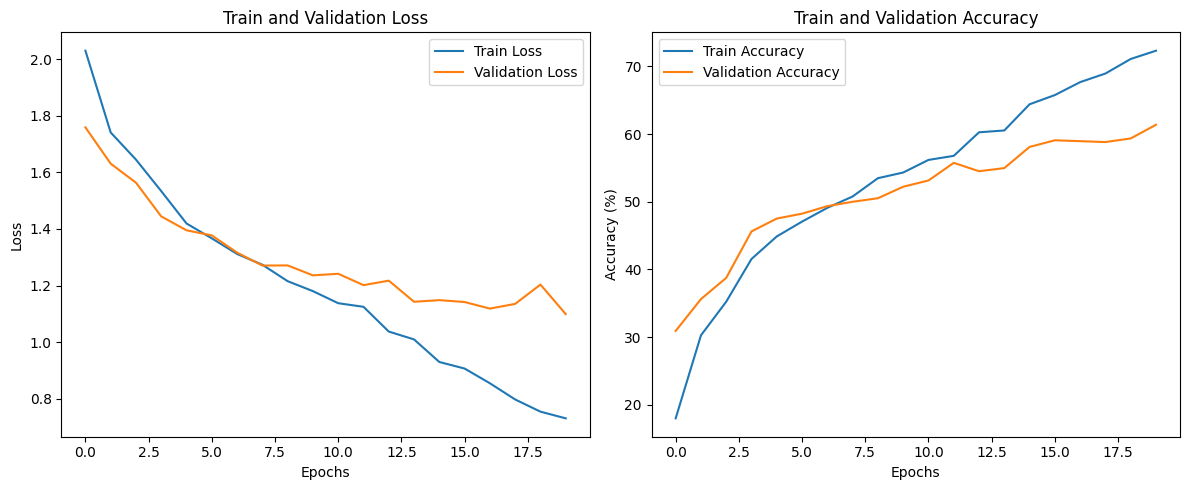

In [10]:
import matplotlib.pyplot as plt

# Provided training and validation loss and accuracy data
train_loss_history = [2.0301, 1.7410, 1.6451, 1.5336, 1.4192, 1.3667, 1.3115, 1.2734, 1.2153, 1.1801, 1.1374, 1.1247, 1.0372, 1.0094, 0.9296, 0.9064, 0.8544, 0.7971, 0.7540, 0.7304]
val_loss_history = [1.7590, 1.6307, 1.5635, 1.4442, 1.3952, 1.3771, 1.3163, 1.2706, 1.2710, 1.2359, 1.2415, 1.2013, 1.2172, 1.1425, 1.1483, 1.1416, 1.1184, 1.1350, 1.2033, 1.0989]

train_acc_history = [18.01, 30.27, 35.24, 41.55, 44.88, 47.07, 49.10, 50.78, 53.48, 54.32, 56.18, 56.78, 60.26, 60.53, 64.40, 65.76, 67.67, 68.94, 71.09, 72.31]
val_acc_history = [30.92, 35.62, 38.76, 45.62, 47.52, 48.24, 49.35, 50.00, 50.52, 52.22, 53.14, 55.75, 54.51, 54.97, 58.10, 59.08, 58.95, 58.82, 59.35, 61.37]

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
import torch
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

# Load the trained model
model = CustomCNN(num_classes=9)  # Replace with the number of classes in your dataset
model.load_state_dict(torch.load("/kaggle/working/skin_cancer_model.pth"))  # Load the saved model
model = model.to(device)
model.eval()  # Set model to evaluation mode

# Define loss function (same as during training)
criterion = nn.CrossEntropyLoss()

def test_model(model, test_loader):
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    # Testing loop
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Collect predictions and true labels for AUC
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.softmax(outputs, dim=1).cpu().numpy()[:, 1])  # Assuming binary classification for AUC
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100.0 * correct / total
    test_auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')  # AUC for multi-class classification
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%, Test AUC: {test_auc:.2f}")
    return test_loss, test_acc, test_auc

# Create test DataLoader (same as train and val loaders)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Run the test
test_loss, test_acc, test_auc = test_model(model, test_loader)


/tmp/ipykernel_30/530619892.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/skin_cancer_model.pth"))  # Load the saved 

RuntimeError: Error(s) in loading state_dict for CustomCNN:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "conv4.weight", "conv4.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "module.conv1.weight", "module.conv1.bias", "module.conv2.weight", "module.conv2.bias", "module.conv3.weight", "module.conv3.bias", "module.conv4.weight", "module.conv4.bias", "module.fc1.weight", "module.fc1.bias", "module.fc2.weight", "module.fc2.bias". 